# Lightweight Fine-Tuning Project

In [1]:
!pip install transformers datasets torch scikit-learn
!pip install transformers[torch] -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 2.7 MB/s eta 0:00:00


## Loading and Evaluating a Foundation Model


In [2]:
import pandas as pd
from transformers import AutoModelForSequenceClassification
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


In [3]:
df_train_raw = pd.read_csv("imdb_train_dataset.csv")
df_test_raw = pd.read_csv("imdb_test_dataset.csv")

In [4]:
print("Training Dataset Preview:")
print(df_train_raw.head())
print("\nTest Dataset Preview:")
print(df_test_raw.head())

Training Dataset Preview:
                                                text  label
0  I rented I AM CURIOUS-YELLOW from my video sto...      0
1  "I Am Curious: Yellow" is a risible and preten...      0
2  If only to avoid making this type of film in t...      0
3  This film was probably inspired by Godard's Ma...      0
4  Oh, brother...after hearing about this ridicul...      0

Test Dataset Preview:
                                                text  label
0  I love sci-fi and am willing to put up with a ...      0
1  Worth the entertainment value of a rental, esp...      0
2  its a totally average film with a few semi-alr...      0
3  STAR RATING: ***** Saturday Night **** Friday ...      0
4  First off let me say, If you haven't enjoyed a...      0


In [5]:
# Count the number of unique labels in the target column
if 'label' in df_train_raw.columns:
    print("\nUnique Labels in Training Dataset:")
    print(df_train_raw['label'].value_counts())
    print("\nUnique Labels in Test Dataset:")
    print(df_train_raw['label'].value_counts())


Unique Labels in Training Dataset:
0    12500
1    12500
Name: label, dtype: int64

Unique Labels in Test Dataset:
0    12500
1    12500
Name: label, dtype: int64


In [6]:
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from datasets import Dataset, DatasetDict

# Split the dataset into training and validation sets
train_df, val_df = train_test_split(df_train_raw, test_size=0.1, stratify=df_train_raw['label'])

# Convert the DataFrames into Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# Define the tokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # GPT-2 requires a pad token

# Tokenize and convert function
def tokenize_and_encode(examples):
    tokenized_inputs = tokenizer(examples['text'], padding="max_length", truncation=True, max_length=512)
    tokenized_inputs['labels'] = examples['label']
    return tokenized_inputs

train_dataset = train_dataset.map(tokenize_and_encode, batched=True)
val_dataset = val_dataset.map(tokenize_and_encode, batched=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/22500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

In [7]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

num_labels = df_train_raw['label'].nunique()
model = AutoModelForSequenceClassification.from_pretrained("gpt2", num_labels=num_labels)
model.config.pad_token_id = tokenizer.pad_token_id

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Performing Parameter-Efficient Fine-Tuning



In [8]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results/peft_model",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    load_best_model_at_end=True,
    weight_decay=0.01,
    logging_dir='./logs/peft_model',
    save_strategy="epoch",
    fp16=True
)


# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    # Compute metrics function here if desired
)

# Start training
trainer.train()

# Evaluate the model
evaluation_results = trainer.evaluate()
print("Evaluation Results:", evaluation_results)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.335900,0.379314
2,0.239100,0.338990


Evaluation Results: {'eval_loss': 0.33899030089378357, 'eval_runtime': 47.6219, 'eval_samples_per_second': 52.497, 'eval_steps_per_second': 6.573, 'epoch': 2.0}


In [9]:
def predict(text: str) -> str:
    device = model.device
    inputs = tokenizer(text, return_tensors="pt", max_length=512, truncation=True, padding=True).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=1)

    return 'Positive' if predictions.item() == 1 else 'Negative'



In [12]:
# Examples to verify results
sentence = "This movie was fantastic! I loved it."
print(predict(sentence))

Positive


In [13]:
# Examples to verify results
sentence = "This movie was awful! I hated it."
print(predict(sentence))

Negative


## Performing Inference and comparison with a PEFT Model



In [14]:
test_dataset = Dataset.from_pandas(df_test_raw)
test_dataset = test_dataset.map(tokenize_and_encode, batched=True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [16]:

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [18]:
# Loading the original model
original_model = AutoModelForSequenceClassification.from_pretrained("gpt2", num_labels=2)
original_model.config.pad_token_id = tokenizer.pad_token_id

# Function to perform the evaluation
def evaluate_model(model, test_dataset, compute_metrics):
    trainer = Trainer(
        model=model,
        args=TrainingArguments(
            output_dir="./results",
            per_device_eval_batch_size=8,
        ),
        compute_metrics=compute_metrics,
    )
    results = trainer.evaluate(test_dataset)
    return results

# Evaluating both models
original_results = evaluate_model(original_model, test_dataset, compute_metrics)
fine_tuned_results = evaluate_model(model, test_dataset, compute_metrics)

print("Original Model Results:", original_results)
print("Fine-Tuned Model Results:", fine_tuned_results)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Original Model Results: {'eval_loss': 0.8232471942901611, 'eval_accuracy': 0.503, 'eval_f1': 0.05749829325646666, 'eval_precision': 0.554904831625183, 'eval_recall': 0.03032, 'eval_runtime': 486.0787, 'eval_samples_per_second': 51.432, 'eval_steps_per_second': 6.429}
Fine-Tuned Model Results: {'eval_loss': 0.3020724654197693, 'eval_accuracy': 0.93832, 'eval_f1': 0.9381567337771717, 'eval_precision': 0.9406466141225671, 'eval_recall': 0.93568, 'eval_runtime': 482.5127, 'eval_samples_per_second': 51.812, 'eval_steps_per_second': 6.477}


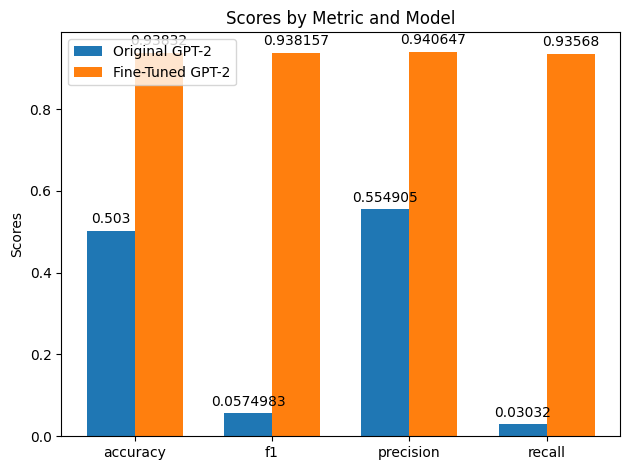

In [19]:

metrics = ['accuracy', 'f1', 'precision', 'recall']
original_scores = [original_results['eval_' + metric] for metric in metrics]
fine_tuned_scores = [fine_tuned_results['eval_' + metric] for metric in metrics]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, original_scores, width, label='Original GPT-2')
rects2 = ax.bar(x + width/2, fine_tuned_scores, width, label='Fine-Tuned GPT-2')

ax.set_ylabel('Scores')
ax.set_title('Scores by Metric and Model')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()